In [1]:
!pip3 install -U segmentation-models
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd

from matplotlib import pyplot as plt
import random
import numpy as np

import segmentation_models as sm
from segmentation_models import Unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.1 MB/s 
Segmentation Models: using `keras` framework.


In [5]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Wound Care Center/azh_wound_care_center_dataset_patches.zip', 'r') as zip_ref: # Me crea las carpetas en content, a partir del .zip
    zip_ref.extractall('.')


# Conecto a W&B:

#!pip install wandb
import wandb
from wandb.keras import WandbCallback

wandb.login(key="845f113db3338e2a17fdb341af93fac698348802")
wandb.init(project="ulceras-por-presion", name="baseline Unet (+ bbone resnet imagenet)", save_code=False)

# Split de datos y creo los .csv

Para esta parte solo necesito correr la primera línea donde extraigo el zip de GDrive

Creo un dataset que contenga los nombres de mis archivos --> ya lo tengo?? uno para train con el nombre del archivo y de su mascara , q deberia ser igual creo y lo mismo para test. Esto me va a permitir hacer el train test split y crear el val_set a partir del df que creé de train.


Creo un dataset con los nombres de las imágenes y de sus labels (coinciden en este caso)
Notar que para hacer esto en ningun momento me meto en la carpeta train/labels, xq yo ya veo q tienen q tener el mismo nombre, entonces uso directamente la de images para ambas columnas

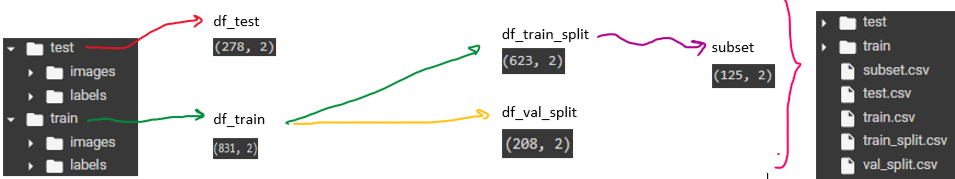

In [6]:
import pandas as pd
import os

df_train = pd.DataFrame()

nombres_imagenes = os.listdir("/content/train/images")
nombres_etiquetas =[ix_imagen for ix_imagen in os.listdir("/content/train/images")] # en este caso mi referencia es el nombre completo, incluso la extension xq se llaman igual las imagenes a sus labels y son el mismo tipo de archivo.

# aca como los nombres son exactamente iguales , no hacía falta la línea de arriba podía driectamente crear dos columnas con los mismos valores:
# nombres_etiquetas = os.listdir("/content/train/images")


df_train['image_name'] = nombres_imagenes
df_train['label_name'] = nombres_etiquetas

df_train
df_train.shape


(831, 2)

Creo un dataset igual pero para el test

In [7]:
import pandas as pd

df_test = pd.DataFrame()

nombres_imagenes = os.listdir("/content/test/images")
nombres_etiquetas =[ix_imagen for ix_imagen in os.listdir("/content/test/images")] # en este caso mi referencia es el nombre completo, incluso la extension xq se llaman igual las imagenes a sus labels y son el mismo tipo de archivo.

# aca como los nombres son exactamente iguales , no hacía falta la línea de arriba podía driectamente crear dos columnas con los mismos valores:
# nombres_etiquetas = os.listdir("/content/train/images")


df_test['image_name'] = nombres_imagenes
df_test['label_name'] = nombres_etiquetas

df_test

df_test.shape

(278, 2)

Del df_train, hago un split para tener df_train_split y df_val_split

In [8]:
from sklearn.model_selection import train_test_split

df_train_split , df_val_split = train_test_split(df_train, test_size = 0.25, shuffle = True, random_state = 42)

df_train_split.shape, df_val_split.shape

((623, 2), (208, 2))

Ahora teniendo esto puedo usar mis dataframes con los nombres ya separados para acceder a los archivos con sus splits de forma ordenada 

In [9]:
# USO SUBSET de mi split PARA EVALUAR CAMBIOS QUE PIENSO IMPLEMENTAR de forma rápida
_, subset = train_test_split(df_train_split, test_size = 0.2, shuffle = True, random_state = 42)
subset.shape

(125, 2)

In [10]:
PATH = "/content"
df_train.to_csv(f"{PATH}/train.csv", index = False)
df_test.to_csv(f"{PATH}/test.csv", index = False)
df_train_split.to_csv(f"{PATH}/train_split.csv", index = False)
df_val_split.to_csv(f"{PATH}/val_split.csv", index = False)
subset.to_csv(f"{PATH}/subset.csv", index = False)
# index False para que no me guarde la columna de lo

# Cargo imágenes y preproceso

Creo una función que reciba una carpeta (con imágenes en un formato legible por cv2.imread) y me devuelve una lista con las imágenes (matrices) de esa carpeta. También puedo pasarle por parámetro una lista con los nomrbes puntuales de los archivos que quiero que carge. Entonces a partir de eso creo X_test y y_test. También lo puedo usar para X_train_split, en lugar de hacerlo de la forma que lo hice antes. Y despeus es muy fácil pasarlo a un array de numpy para ya poder trabajarlo como hice más abajo.
Por último, le agregué un parámetro "binario" que si es True, entonces pasa la imagen primero a grayscale (de 3 valores a 1 solo) y desp lo q hice es poner un threshold para que en lugar de tomar valores hasta 255 tome solo 0 y 1

In [11]:
import numpy as np
import tifffile as tiff
import cv2
import os

def cargar_imagenes_filtradas(folder, filename_list = np.array([0]), binario = False): # si no le paso el 2do parametro, carga todas las que este dentro de la carpeta folder que recibe en el primer parametro
    
    images = []
    if filename_list.all() == 0:
      filename_list = os.listdir(folder)


    for filename in filename_list: # os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename)) # al ser png viene en BGR
        if binario:
          img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # convierte a gray, o sea pasa de 3 valores a 1 solo
          img[img<255] = 0    
          img[img==255] = 1                                  # para tener 1 y 0 en vez de hasta 255
        else: 
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # esto lo agego xq si no me la devuelve como negativo, xq cv2 trabaja en BGR en vez de en RGB
                
        if img is not None:
            images.append(img)

    return np.array(images).astype(np.float32) # puedo sacarle si quiero el np.array si no quiero q me devuelva en objeto de numpy y puedo reconvertirla a uint8 con




A partir de los df creados, cargo las imágenes con la función que creé para guardarlas en variables de tipo numpy


In [12]:
X_train = cargar_imagenes_filtradas("/content/train/images", df_train["image_name"]) 
y_train = cargar_imagenes_filtradas("/content/train/labels", df_train["label_name"], binario = True) 

X_train_split = cargar_imagenes_filtradas("/content/train/images", df_train_split["image_name"]) 
y_train_split = cargar_imagenes_filtradas("/content/train/labels", df_train_split["label_name"], binario = True) 

X_val_split = cargar_imagenes_filtradas("/content/train/images", df_val_split["image_name"])
y_val_split = cargar_imagenes_filtradas("/content/train/labels", df_val_split["label_name"], binario = True)

X_test = cargar_imagenes_filtradas("/content/test/images",df_test['image_name']) #
y_test = cargar_imagenes_filtradas("/content/test/labels", df_test['label_name'],binario = True) 

# el subset por ahora no lo uso xq ya con el split puedo entrenar bastante bien.

In [13]:
X_train.shape, X_train_split.shape, X_val_split.shape, X_test.shape

((831, 224, 224, 3),
 (623, 224, 224, 3),
 (208, 224, 224, 3),
 (278, 224, 224, 3))

Le agrego a mis etiquetas la última dimensión para que encaje bien todo

In [14]:
# Si se lo quiero sacar desp (por ej. para plotearlo con imshow, uso np.squeeze() )
y_train = np.expand_dims(y_train,-1)
y_test = np.expand_dims(y_test,-1)
y_train_split = np.expand_dims(y_train_split,-1)
y_val_split = np.expand_dims(y_val_split,-1)

y_train.shape, y_train_split.shape, y_val_split.shape, y_test.shape

((831, 224, 224, 1),
 (623, 224, 224, 1),
 (208, 224, 224, 1),
 (278, 224, 224, 1))

Chequeo valores máximos:

In [15]:
X_test.max() , X_train.max(), X_train_split.max(), np.unique(y_test), np.unique(y_train) # chequeo los valores que toman.

(255.0,
 255.0,
 255.0,
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32))

### Verifico que coincidan las imágenes de X con y

Para train:

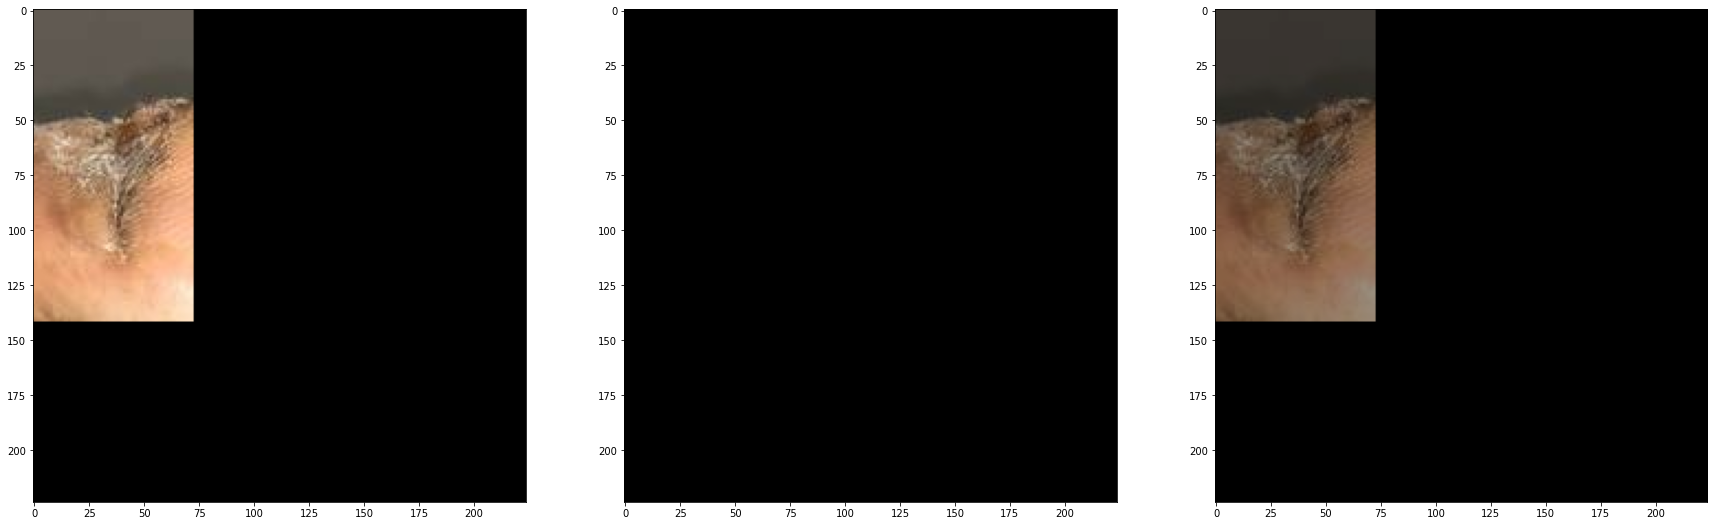

In [ ]:
image_number = random.randint(0, len(X_train))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

img = (X_train[image_number]).astype(np.uint8)
mask = (np.squeeze(y_train[image_number]))

ax1.imshow(img)
ax2.imshow(mask, cmap='Greys_r', interpolation='nearest')
ax3.imshow(img)
ax3.imshow(mask, cmap='Greys_r', interpolation='nearest', alpha=0.4)
plt.show()

Para train_split:

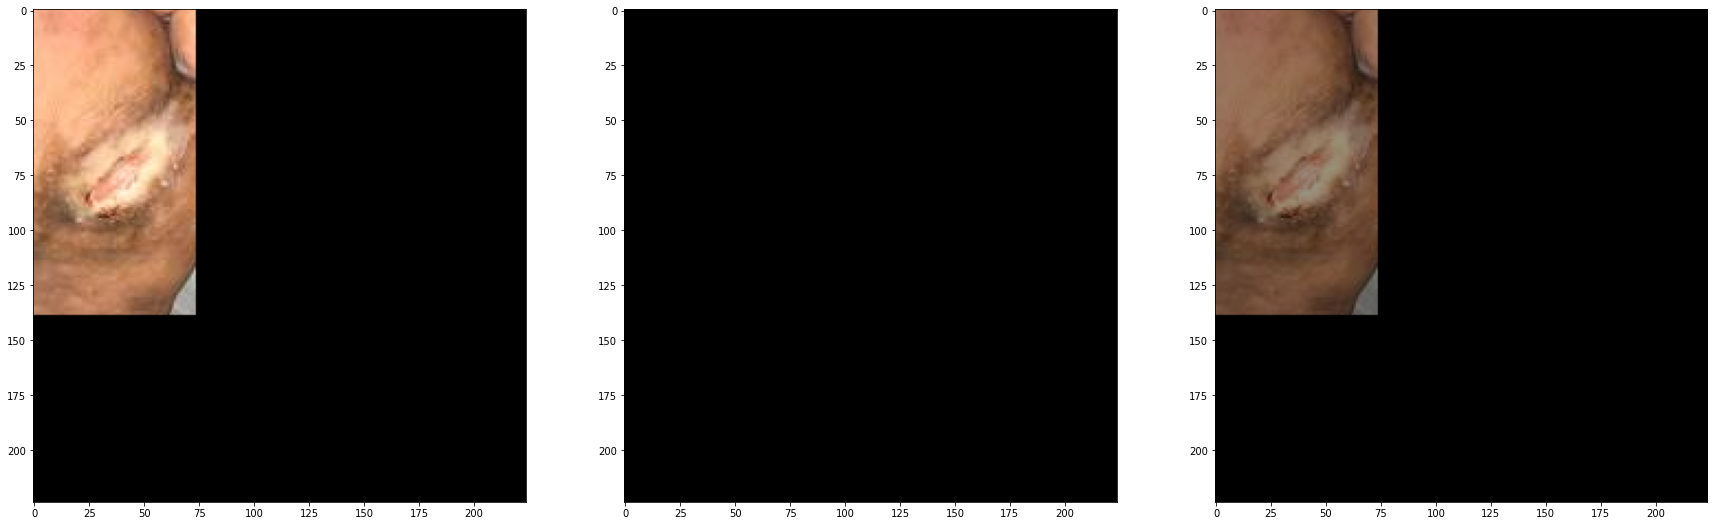

In [ ]:
image_number = random.randint(0, len(X_train_split))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

img = (X_train_split[image_number]).astype(np.uint8)
mask = (np.squeeze(y_train_split[image_number]))

ax1.imshow(img)
ax2.imshow(mask, cmap='Greys_r', interpolation='nearest')
ax3.imshow(img)
ax3.imshow(mask, cmap='Greys_r', interpolation='nearest', alpha=0.4)
plt.show()


Para val:

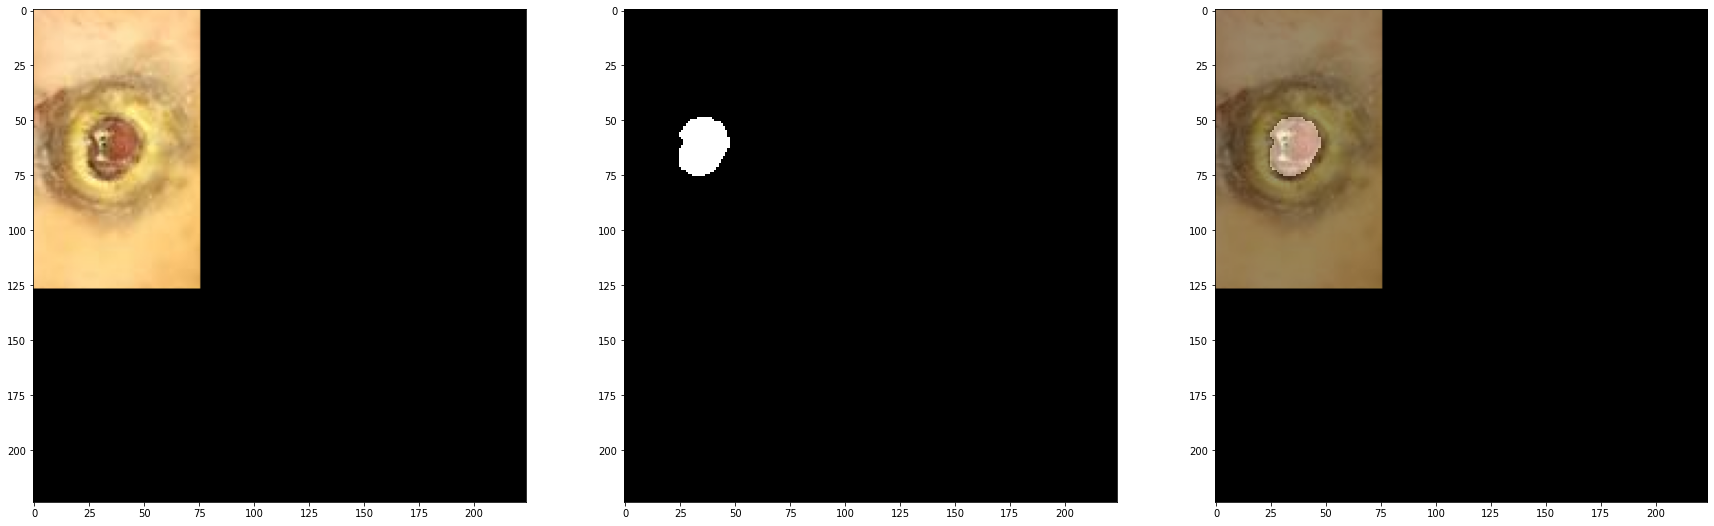

In [ ]:
image_number = random.randint(0, len(X_val_split))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))



img = (X_val_split[image_number]).astype(np.uint8)
mask = (np.squeeze(y_val_split[image_number]))

ax1.imshow(img)
ax2.imshow(mask, cmap='Greys_r', interpolation='nearest')
ax3.imshow(img)
ax3.imshow(mask, cmap='Greys_r', interpolation='nearest', alpha=0.4)
plt.show()


Para test:

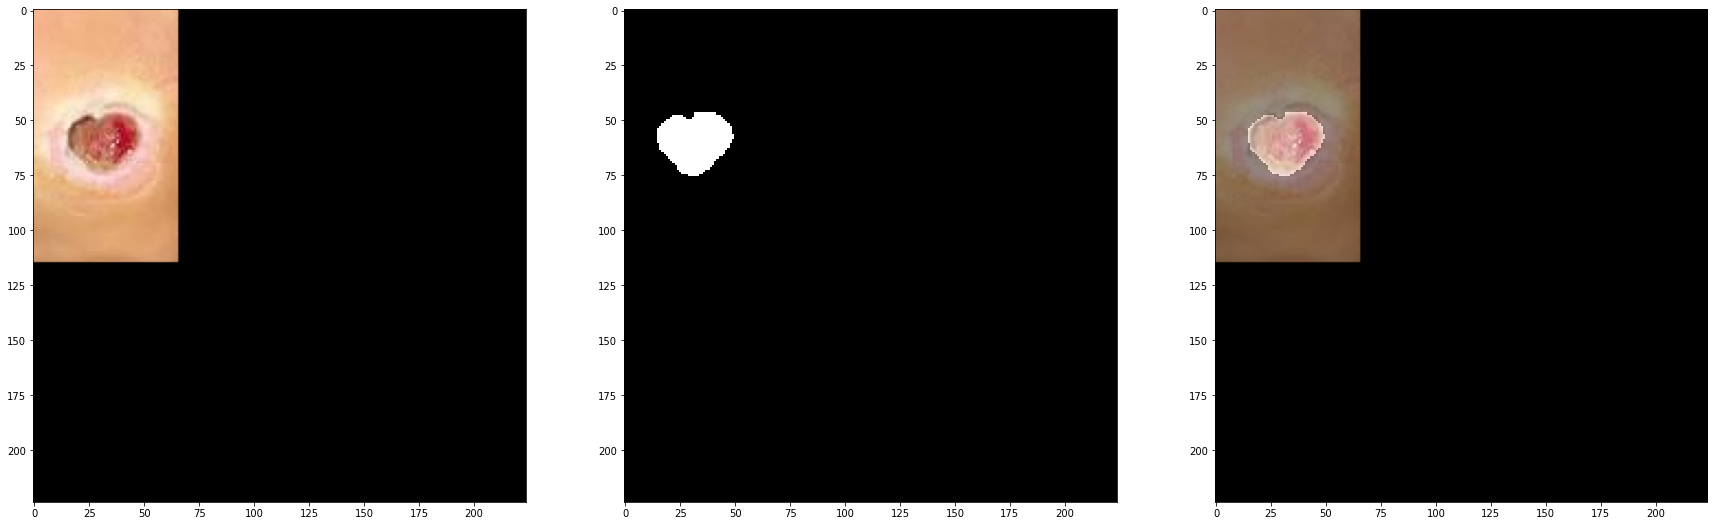

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
image_number = random.randint(0, len(X_test))

img = (X_test[image_number]).astype(np.uint8)
mask = (np.squeeze(y_test[image_number]))

ax1.imshow(img)
ax2.imshow(mask, cmap='Greys_r', interpolation='nearest')
ax3.imshow(img)
ax3.imshow(mask, cmap='Greys_r', interpolation='nearest', alpha=0.4)
plt.show()


# Creo tensor a partir de los nparrays creados, para poder entrenar mi modelo
Lo hago a partir de una función que me permita luego elegir con que sets quiero cargar a mi tensor para entrenar de forma más práctica

Parte de todo este proceso podría haberlo hecho con tf en lugar de np, como lo hice en el Colab 4 UPP Seg Bin donde decodee las png usando funciones de tf, y tb. lo hice a partir de las tablas de pandas directamente y no desde los .npy

In [16]:
BATCH_SIZE = 32

# def decode(img, label):

#   img = tf.cast(img, tf.float32)
#   label = tf.cast(label, tf.float32)
#   return img,label

def npy2tf(X,y): # este sería el equivalente a load_ds del Colab 4 (anterior)
    ds = tf.data.Dataset.from_tensor_slices((X,y))
    ds = ds.shuffle(2048)  
    ds = ds.batch(BATCH_SIZE)
    #ds = ds.map(decode)
    return ds


In [17]:
tf_train = npy2tf(X_train_split, y_train_split)
tf_val = npy2tf(X_val_split , y_val_split)
tf_train , tf_val

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>)

In [18]:
#tf_train = npy2tf(X_train, y_train)
#tf_val = npy2tf(X_test , y_test )
#tf_train , tf_val

Itero por batches y chequeo dimensión:

In [19]:
for img,label in tf_train.take(1): # el parámetro corresopnde a la cant de batches. En este caso 1 solo batch
  print(img.shape,label.shape)

for img,label in tf_val.take(1): # el parámetro corresopnde a la cant de batches. En este caso 1 solo batch
  print(img.shape,label.shape)


(32, 224, 224, 3) (32, 224, 224, 1)
(32, 224, 224, 3) (32, 224, 224, 1)


# Baseline

Cargo el modelo

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'resnet34' #"mobilenetv2" 

model = sm.Linknet(BACKBONE, encoder_weights = "imagenet") #sm.Unet(BACKBONE, encoder_weights = "imagenet")
model.compile("Adam", loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score]) # ver dice score
#print(model.summary()) 



# Checkpoint during training for best model
my_callbacks = [
        ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), # para val_iou_score es mode: "max"
        EarlyStopping(
            monitor="val_loss", # puedo probar con "val_iou_score" en todas, aunque anda medio raro no se xq con lo de la patience
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=7, min_lr=0.00001) # cuando supera la patience vuelve al valor máximo antes de bajar el lr?
]


85532672/85521592 [==============================] - 1s 0us/step


Modelo 2:

tf.keras.applications.mobilenet_v2.preprocess_input(
    np.copy(X_train_split), data_format=None
)
X_train_split
https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input
https://keras.io/guides/transfer_learning/

from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers import Input
input_tensor = Input(shape=(224,224, 3)) # or you could put (None, None, 3) for shape
model = MobileNetV2(input_tensor = input_tensor, alpha = 1.0, include_top = True, weights=’imagenet’)

WandB

wandb.config = {
  "algorithm": "U-Net",
  "backbone": "resnet34",
  "loss": "bce_jaccard_loss",
  "metrics": "iou_score",
  "learning_rate": 0.001, # Adam tiene por default lr= 0.001
  "epochs": 50,
  "batch_size": 16,
}

Entreno:

In [ ]:
history = model.fit(tf_train, epochs = 50, validation_data= tf_val, callbacks=my_callbacks  )#, callbacks=[WandbCallback()] )
history

## Gráficos del entrenamiento:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
iou_score = history.history['iou_score']  # estas variables estan en histort.history
val_iou_score = history.history['val_iou_score']  # estas variables estan en histort.history

plt.plot(epochs, iou_score, 'y', label='Training acc')
plt.plot(epochs, val_iou_score, 'r', label='Validation acc')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

KeyError: ignored

Gráficos entrenamiento modelo 2:

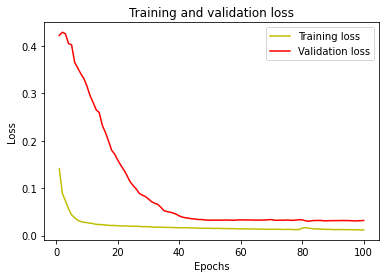

In [ ]:
#training_history
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
dice_score = training_history.history['dice_score']
val_dice_score = training_history.history['val_dice_score']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, dice_score, 'y', label='Training dice_score')
plt.plot(epochs, val_dice_score, 'r', label='Validation dice_score')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('dice_score')
plt.legend()
plt.show()

KeyError: ignored

## IoU Score del Test set:

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


IoU socre is:  0.7664854378727668


## Visualizo predicciones y comparo vs test:

TypeError: ignored

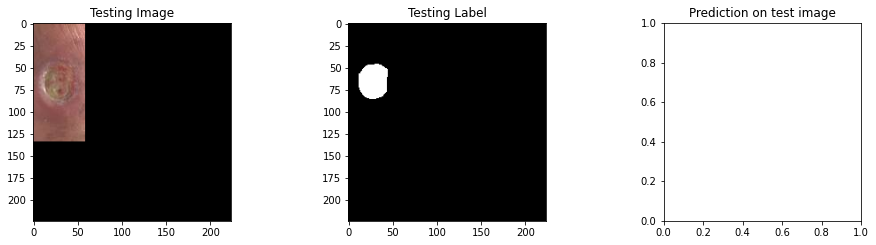

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:][:,:]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

image_number = random.randint(0, len(y_test))
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:].astype(np.uint8))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.squeeze(ground_truth[:,:,:]), cmap ="gray")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction) #,cmap='gray')

plt.show()

## Códigos que deberían ser archivos que importo, como en https://github.dev/uwm-bigdata/wound-segmentation 

### Modelo github:

In [23]:
# -*- coding: utf-8 -*-

""" Deeplabv3+ model for Keras.
This model is based on this repo:
https://github.com/bonlime/keras-deeplab-v3-plus

MobileNetv2 backbone is based on this repo:
https://github.com/JonathanCMitchell/mobilenet_v2_keras

# Reference
- [Encoder-Decoder with Atrous Separable Convolution
    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Xception: Deep Learning with Depthwise Separable Convolutions]
    (https://arxiv.org/abs/1610.02357)
- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for
    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

from keras.models import Model
from keras import layers
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.utils import get_source_inputs
from keras import backend as K
from keras.applications import imagenet_utils
from keras.utils import conv_utils
from keras.utils.data_utils import get_file

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/rdiazgar/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/rdiazgar/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"

class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """

    def __init__(self, upsampling=(2, 2), output_size=None, data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)

        self.data_format = K.image_data_format()
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.output_size = conv_utils.normalize_tuple(
                output_size, 2, 'output_size')
            self.upsampling = None
        else:
            self.output_size = None
            self.upsampling = conv_utils.normalize_tuple(
                upsampling, 2, 'upsampling')

    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.output_size[0]
            width = self.output_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        if self.upsampling:
            return tf.compat.v1.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True)
        else:
            return tf.compat.v1.image.resize_bilinear(inputs, (self.output_size[0],
                                                       self.output_size[1]),
                                              align_corners=True)

    def get_config(self):
        config = {'upsampling': self.upsampling,
                  'output_size': self.output_size,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return K.relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2'
              , OS=16, alpha=1.):
    """ Instantiates the Deeplabv3+ architecture

    Optionally loads weights pre-trained
    on PASCAL VOC. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc)
            or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images
        classes: number of desired classes. If classes != 21,
            last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone

    # Returns
        A Keras model instance.

    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`

    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            # Input layer
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                            int(np.ceil(input_shape[1] / 4))))(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if classes == 21:
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model


def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return imagenet_utils.preprocess_input(x, mode='tf')


### Métricas github:

In [24]:
# ------------------------------------------------------------ #
#
# file : metrics.py
# author : CM
# Metrics for evaluation
#
# ------------------------------------------------------------ #
from keras import backend as K


# dice coefficient
'''
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
'''
# the deeplab version of dice coefficient
def dice_coef(y_true, y_pred):
    smooth = 0.00001
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / ((K.sum(y_true_f) + K.sum(y_pred_f)) + smooth)
    return score


# Recall (true positive rate)
def recall(truth, prediction):
    TP = K.sum(K.round(K.clip(truth * prediction, 0, 1)))
    P = K.sum(K.round(K.clip(truth, 0, 1)))
    return TP / (P + K.epsilon())


# Specificity (true negative rate)
def specificity(truth, prediction):
    TN = K.sum(K.round(K.clip((1-truth) * (1-prediction), 0, 1)))
    N = K.sum(K.round(K.clip(1-truth, 0, 1)))
    return TN / (N + K.epsilon())


# Precision (positive prediction value)
def precision(truth, prediction):
    TP = K.sum(K.round(K.clip(truth * prediction, 0, 1)))
    FP = K.sum(K.round(K.clip((1-truth) * prediction, 0, 1)))
    return TP / (TP + FP + K.epsilon())


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### Data github: (Datagen)

In [25]:
class DataGen:

    def __init__(self, path, split_ratio, x, y, color_space='rgb'):
        self.x = x
        self.y = y
        self.path = path
        self.color_space = color_space
        self.path_train_images = path + "train/images/"
        self.path_train_labels = path + "train/labels/"
        self.path_test_images = path + "test/images/"
        self.path_test_labels = path + "test/labels/"
        self.image_file_list = get_png_filename_list(self.path_train_images)
        self.label_file_list = get_png_filename_list(self.path_train_labels)
        self.image_file_list[:], self.label_file_list[:] = self.shuffle_image_label_lists_together()
        self.split_index = int(split_ratio * len(self.image_file_list))
        self.x_train_file_list = self.image_file_list[self.split_index:]
        self.y_train_file_list = self.label_file_list[self.split_index:]
        self.x_val_file_list = self.image_file_list[:self.split_index]
        self.y_val_file_list = self.label_file_list[:self.split_index]
        self.x_test_file_list = get_png_filename_list(self.path_test_images)
        self.y_test_file_list = get_png_filename_list(self.path_test_labels)

    def generate_data(self, batch_size, train=False, val=False, test=False):
        """Replaces Keras' native ImageDataGenerator."""
        try:
            if train is True:
                image_file_list = self.x_train_file_list
                label_file_list = self.y_train_file_list
            elif val is True:
                image_file_list = self.x_val_file_list
                label_file_list = self.y_val_file_list
            elif test is True:
                image_file_list = self.x_test_file_list
                label_file_list = self.y_test_file_list
        except ValueError:
            print('one of train or val or test need to be True')

        i = 0
        while True:
            image_batch = []
            label_batch = []
            for b in range(batch_size):
                if i == len(self.x_train_file_list):
                    i = 0
                if i < len(image_file_list):
                    sample_image_filename = image_file_list[i]
                    sample_label_filename = label_file_list[i]
                    # print('image: ', image_file_list[i])
                    # print('label: ', label_file_list[i])
                    if train or val:
                        image = cv2.imread(self.path_train_images + sample_image_filename, 1)
                        label = cv2.imread(self.path_train_labels + sample_label_filename, 0)
                    elif test is True:
                        image = cv2.imread(self.path_test_images + sample_image_filename, 1)
                        label = cv2.imread(self.path_test_labels + sample_label_filename, 0)
                    # image, label = self.change_color_space(image, label, self.color_space)
                    label = np.expand_dims(label, axis=2)
                    if image.shape[0] == self.x and image.shape[1] == self.y:
                        image_batch.append(image.astype("float32"))
                    else:
                        print('the input image shape is not {}x{}'.format(self.x, self.y))
                    if label.shape[0] == self.x and label.shape[1] == self.y:
                        label_batch.append(label.astype("float32"))
                    else:
                        print('the input label shape is not {}x{}'.format(self.x, self.y))
                i += 1
            if image_batch and label_batch:
                image_batch = normalize(np.array(image_batch))
                label_batch = normalize(np.array(label_batch))
                yield (image_batch, label_batch)

    def get_num_data_points(self, train=False, val=False):
        try:
            image_file_list = self.x_train_file_list if val is False and train is True else self.x_val_file_list
        except ValueError:
            print('one of train or val need to be True')

        return len(image_file_list)

    def shuffle_image_label_lists_together(self):
        combined = list(zip(self.image_file_list, self.label_file_list))
        random.shuffle(combined)
        return zip(*combined)

    @staticmethod
    def change_color_space(image, label, color_space):
        if color_space.lower() is 'hsi' or 'hsv':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            label = cv2.cvtColor(label, cv2.COLOR_BGR2HSV)
        elif color_space.lower() is 'lab':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            label = cv2.cvtColor(label, cv2.COLOR_BGR2LAB)
        return image, label
def normalize(arr):
    diff = np.amax(arr) - np.amin(arr)
    diff = 255 if diff == 0 else diff
    arr = arr / np.absolute(diff)
    return arr


def get_png_filename_list(path):
    file_list = []
    for FileNameLength in range(0, 500):
        for dirName, subdirList, fileList in os.walk(path):
            for filename in fileList:
                # check file extension
                if ".png" in filename.lower() and len(filename) == FileNameLength:
                    file_list.append(filename)
            break
    file_list.sort()
    return file_list


def get_jpg_filename_list(path):
    file_list = []
    for FileNameLength in range(0, 500):
        for dirName, subdirList, fileList in os.walk(path):
            for filename in fileList:
                # check file extension
                if ".jpg" in filename.lower() and len(filename) == FileNameLength:
                    file_list.append(filename)
            break
    file_list.sort()
    return file_list


def load_jpg_images(path):
    file_list = get_jpg_filename_list(path)
    temp_list = []
    for filename in file_list:
        img = cv2.imread(path + filename, 1)
        temp_list.append(img.astype("float32"))

    temp_list = np.array(temp_list)
    # x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
    return temp_list, file_list


def load_png_images(path):

    temp_list = []
    file_list = get_png_filename_list(path)
    for filename in file_list:
        img = cv2.imread(path + filename, 1)
        temp_list.append(img.astype("float32"))

    temp_list = np.array(temp_list)
    #temp_list = np.reshape(temp_list,(temp_list.shape[0], temp_list.shape[1], temp_list.shape[2], 3))
    return temp_list, file_list


def load_data(path):
    # path_train_images = path + "train/images/padded/"
    # path_train_labels = path + "train/labels/padded/"
    # path_test_images = path + "test/images/padded/"
    # path_test_labels = path + "test/labels/padded/"
    path_train_images = path + "train/images/"
    path_train_labels = path + "train/labels/"
    path_test_images = path + "test/images/"
    path_test_labels = path + "test/labels/"
    x_train, train_image_filenames_list = load_png_images(path_train_images)
    y_train, train_label_filenames_list = load_png_images(path_train_labels)
    x_test, test_image_filenames_list = load_png_images(path_test_images)
    y_test, test_label_filenames_list = load_png_images(path_test_labels)
    x_train = normalize(x_train)
    y_train = normalize(y_train)
    x_test = normalize(x_test)
    y_test = normalize(y_test)
    return x_train, y_train, x_test, y_test, test_label_filenames_list


def load_test_images(path):
    path_test_images = path + "test/images/"
    x_test, test_image_filenames_list = load_png_images(path_test_images)
    x_test = normalize(x_test)
    return x_test, test_image_filenames_list


def save_results(np_array, color_space, outpath, test_label_filenames_list):
    i = 0
    for filename in test_label_filenames_list:
        # predict_img = np.reshape(predict_img,(predict_img[0],predict_img[1]))
        pred = np_array[i]
        # if color_space.lower() is 'hsi' or 'hsv':
        #     pred = cv2.cvtColor(pred, cv2.COLOR_HSV2RGB)
        # elif color_space.lower() is 'lab':
        #     pred = cv2.cvtColor(pred, cv2.COLOR_Lab2RGB)
        cv2.imwrite(outpath + filename, pred * 255.)
        i += 1


def save_rgb_results(np_array, outpath, test_label_filenames_list):
    i = 0
    for filename in test_label_filenames_list:
        # predict_img = np.reshape(predict_img,(predict_img[0],predict_img[1]))
        cv2.imwrite(outpath + filename, np_array[i] * 255.)
        i += 1


def save_history(model, model_name, training_history, dataset, n_filters, epoch, learning_rate, loss,
                 color_space, path=None, temp_name=None):
    save_weight_filename = temp_name if temp_name else str(datetime.datetime.now())
    model.save('{}{}.hdf5'.format(path, save_weight_filename))
    with open('{}{}.json'.format(path, save_weight_filename), 'w') as f:
        json.dump(training_history.history, f, indent=2)

    json_list = ['{}{}.json'.format(path, save_weight_filename)]
    for json_filename in json_list:
        with open(json_filename) as f:
            # convert the loss json object to a python dict
            loss_dict = json.load(f)
        print_list = ['loss', 'val_loss', 'dice_coef', 'val_dice_coef']
        for item in print_list:
            item_list = []
            if item in loss_dict:
                item_list.extend(loss_dict.get(item))
                plt.plot(item_list)
        plt.title('model:{} lr:{} epoch:{} #filtr:{} Colorspaces:{}'.format(model_name, learning_rate,
                                                                            epoch, n_filters, color_space))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train_loss', 'test_loss', 'train_dice', 'test_dice'], loc='upper left')
        plt.savefig('{}{}.png'.format(path, save_weight_filename))
        plt.show()
        plt.clf()





## MobilenetV2 del Paper (github)

In [33]:
from keras.utils.generic_utils import CustomObjectScope
from keras.models import load_model

model = Deeplabv3(input_shape=(224, 224, 3), classes=1)
model_name = 'MobilenetV2'

# Si quiero llamar al modelo que bajé --> tb puedo partir de este modelo para q entrene más rápido todo.
with CustomObjectScope({'relu6': relu6,'DepthwiseConv2D': DepthwiseConv2D, 'BilinearUpsampling': BilinearUpsampling}):
    model = load_model('/content/drive/MyDrive/pIASHIBA Proyecto /Modelos guardados/2019-12-19 01%3A53%3A15.480800.hdf5'
                       , custom_objects={'dice_coef': dice_coef, 'precision':precision, 'recall':recall})
    



In [34]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#dataset = 'Medetec_foot_ulcer_224'
dataset = 'Medetec_foot_ulcer_224'

input_dim_x=224
input_dim_y=224
#data_gen = DataGen('/content/drive/MyDrive/pIASHIBA Proyecto /Datos/' + dataset + '/', split_ratio=0.2, x=input_dim_x, y=input_dim_y)
data_gen = DataGen("/content/" , split_ratio=0.2, x=input_dim_x, y=input_dim_y)

n_filters = 32
batch_size = 16 #2
epochs = 100 #2000
learning_rate = 1e-4
loss = 'binary_crossentropy'


es = EarlyStopping(monitor='val_dice_coef', patience=20, mode='max', restore_best_weights=True)


#model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=[dice_coef, precision, recall])


# training_history = model.fit_generator(tf_train, 
#                                        #batch_size=batch_size,                                    
#                                        callbacks = [es],
#                                        validation_data=tf_val, 
#                                        #verbose=1,                                     
#                                        epochs=epochs)

#training_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs
#                             , validation_split=0.2, verbose=1, callbacks=[])

# model.summary()


#training_history = model.fit_generator(tf_train,                                     
#                                       callbacks = [es],
#                                       validation_data=tf_val,                                      
#                                       epochs=epochs)

# model.summary()

model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=[dice_coef, precision, recall])
training_history = model.fit(data_gen.generate_data(batch_size=batch_size, train=True),
                                       steps_per_epoch=int(data_gen.get_num_data_points(train=True) / batch_size),
                                       callbacks=[es],
                                       validation_data=data_gen.generate_data(batch_size=batch_size, val=True),
                                       validation_steps=int(data_gen.get_num_data_points(val=True) / batch_size),
                                       epochs=epochs)

Epoch 1/100
41/41 [==============================] - 19s 342ms/step - loss: 0.0701 - dice_coef: 0.8264 - precision: 0.8479 - recall: 0.8147 - val_loss: 0.0421 - val_dice_coef: 0.8664 - val_precision: 0.9129 - val_recall: 0.8269
Epoch 2/100
41/41 [==============================] - 13s 327ms/step - loss: 0.0462 - dice_coef: 0.8498 - precision: 0.8417 - recall: 0.8617 - val_loss: 0.0407 - val_dice_coef: 0.8506 - val_precision: 0.9392 - val_recall: 0.7834
Epoch 3/100
41/41 [==============================] - 14s 336ms/step - loss: 0.0343 - dice_coef: 0.8555 - precision: 0.8676 - recall: 0.8472 - val_loss: 0.0400 - val_dice_coef: 0.8395 - val_precision: 0.9441 - val_recall: 0.7583
Epoch 4/100
41/41 [==============================] - 14s 335ms/step - loss: 0.0294 - dice_coef: 0.8563 - precision: 0.8767 - recall: 0.8394 - val_loss: 0.0349 - val_dice_coef: 0.8273 - val_precision: 0.9510 - val_recall: 0.7401
Epoch 5/100
41/41 [==============================] - 14s 346ms/step - loss: 0.0245 - dic

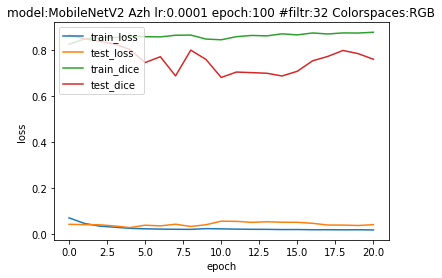

<Figure size 432x288 with 0 Axes>

In [35]:
### save the model weight file and its training history
import datetime
import json

model_name = 'MobileNetV2 Azh'
save_history(model, model_name, training_history, dataset, n_filters, epochs, learning_rate, loss, color_space='RGB',
             path="/content/drive/MyDrive/pIASHIBA Proyecto /Modelos guardados/")

### Predict github modelo 2:

In [ ]:
import cv2
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope



# settings
input_dim_x = 224
input_dim_y = 224
color_space = 'rgb'

path = "/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec_foot_ulcer_224/" #'./data/Medetec_foot_ulcer_224/'
weight_file_name = "2022-07-07 23:43:51.128039.hdf5" #'2019-12-19 01%3A53%3A15.480800.hdf5'
pred_save_path = "2022-07-07 23:43:51.128039/" #'2019-12-19 01%3A53%3A15.480800/'
# tengo q crear una carpeta en predictions con este nombre xq save_results abajo no me la crea, solo mete los archivos si es q existe la carpeta.
# ver como hacer q la cree si no existe antes de meter todo, seguro con import os makedir o algo asi...

data_gen = DataGen(path, split_ratio=0.0, x=input_dim_x, y=input_dim_y, color_space=color_space)
x_test, test_label_filenames_list = load_test_images(path)


model = Deeplabv3(input_shape=(input_dim_x, input_dim_y, 3), classes=1)
model = load_model('/content/drive/MyDrive/pIASHIBA Proyecto /Modelos guardados/' + weight_file_name
               , custom_objects={'recall':recall,
                                 'precision':precision,
                                 'dice_coef': dice_coef,
                                 'relu6':relu6,
                                 'DepthwiseConv2D':DepthwiseConv2D,
                                 'BilinearUpsampling':BilinearUpsampling})





1/1 [==============================] - 1s 1s/step


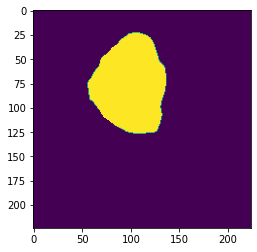

In [ ]:
for image_batch, label_batch in data_gen.generate_data(batch_size=len(x_test), test=True):
    prediction = model.predict(image_batch, verbose=1) 
    save_results(prediction, 'rgb', path + 'test/predictions/' + pred_save_path, test_label_filenames_list)
    break

plt.imshow((prediction[6][:,:,0] > 0.2).astype(np.uint8))

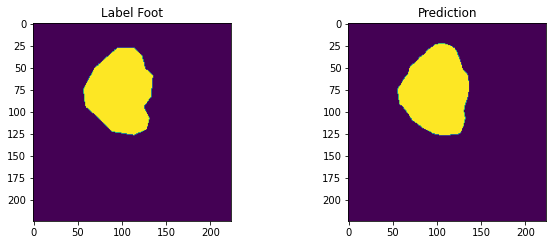

In [ ]:
def load_test_images(path):
    path_test_images = path + "test/images/"
    x_test, test_image_filenames_list = load_png_images(path_test_images)
    x_test = normalize(x_test)
    return x_test, test_image_filenames_list
#prediction = model.predict(imageAzh)

#imageAzh = cv2.imread("/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec_foot_ulcer_224/train/images/foot-ulcer-0014.png")
nroImagen = "0028_2"
imageFoot = cv2.imread(f"/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec_foot_ulcer_224/test/images/foot-ulcer-{nroImagen}.png")
#imageFoot = cv2.cvtColor(imageFoot, cv2.COLOR_BGR2RGB)
imageFoot = normalize(imageFoot)
imageFoot = imageFoot.reshape(1,224,224,3)
prediction = model.predict(imageFoot)

labelFoot = cv2.imread(f"/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec_foot_ulcer_224/test/labels/foot-ulcer-{nroImagen}.png",0)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Label Foot')
plt.imshow(labelFoot)
plt.subplot(232)
plt.title('Prediction')
plt.imshow((prediction[0,:,:,0] > 0.2).astype(np.uint8))

plt.show()


In [ ]:
imageFoot = cv2.imread("/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec_foot_ulcer_224/train/images/foot-ulcer-0001.png")
labelFoot = cv2.imread("/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Medetec_foot_ulcer_224/train/labels/foot-ulcer-0001.png")
imageFoot.shape, labelFoot.shape
np.unique(imageFoot), np.unique(labelFoot)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
imageAzh = cv2.imread("/content/train/images/05bf122b0e8bf667fc2aeedd8b70d9f3_0.png")
labelAzh = cv2.imread("/content/train/labels/05bf122b0e8bf667fc2aeedd8b70d9f3_0.png")
imageAzh.shape, labelAzh.shape
np.unique(imageAzh), np.unique(labelAzh)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177